In [9]:
# import libraries
from pprint import pprint
import importlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import matplotlib.animation as animation
from datetime import timedelta
import geopandas as gpd
import matplotlib.animation as animation
from PIL import Image
import io
from datetime import datetime
from owid import catalog

# my function
import plot_data as pl
import transform_data as td
import machine_learning_model as mlm

# Variables
cat = catalog.find(namespace="covid")
tb_country_cases_deaths = cat.iloc[1].load()  
tb_country_vac = cat.iloc[41].load() 
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

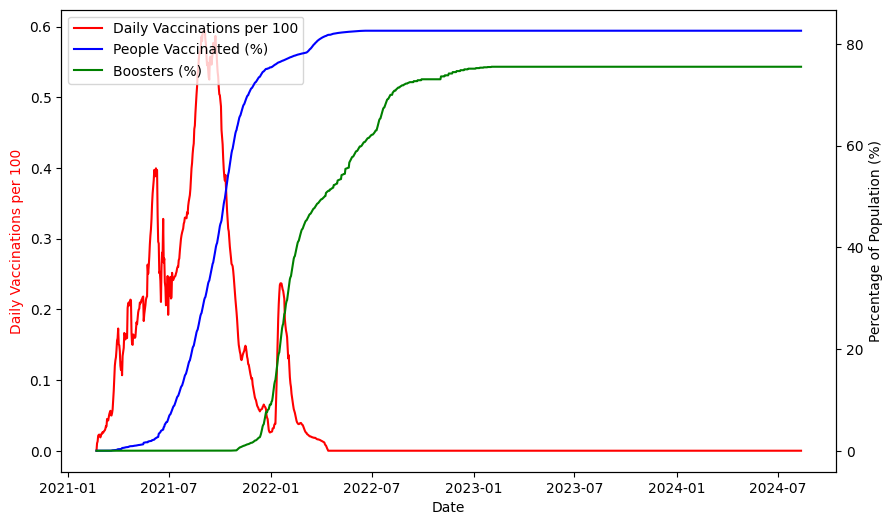

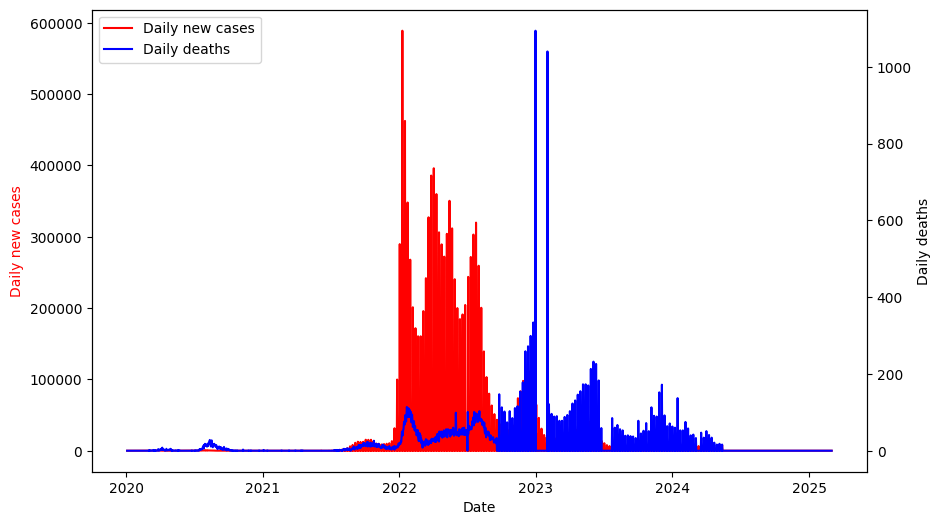

In [255]:
# Transform data
# --------------------------------
importlib.reload(td)
importlib.reload(pl)
features_cd = ["new_cases", "new_deaths"]
# df_cases, df_deaths = td.process_data_by_country(tb_country_cases_deaths, features_cd)

features_vac = ["daily_people_vaccinated_smoothed_per_hundred", 
        "people_fully_vaccinated_per_hundred", 
        "total_boosters_per_hundred"]
df_daily_vac_p100, df_ppl_vac_p100, df_boosters_p100 = td.process_data_by_country(tb_country_vac, features_vac)

# Fix specific errors in the data
df_ppl_vac_p100, df_boosters_p100 = td.specific_corrections(df_ppl_vac_p100, df_boosters_p100)

# Plot vaccination data.
country = 'Australia'
pl.plot_country_vac(country, df_daily_vac_p100, df_ppl_vac_p100, df_boosters_p100)
pl.plot_country_cd(country, df_cases, df_deaths)

In [238]:
import pandas as pd

# Reshape case and death DataFrames into long format
df_cases_long = df_cases.reset_index().melt(id_vars='date', var_name='country', value_name='new_cases')
df_deaths_long = df_deaths.reset_index().melt(id_vars='date', var_name='country', value_name='new_deaths')

# Reshape vaccination DataFrames into long format
df_daily_vac_long = df_daily_vac_p100.reset_index().melt(id_vars='date', var_name='country', value_name='daily_vaccinated_per_100')
df_ppl_vac_long = df_ppl_vac_p100.reset_index().melt(id_vars='date', var_name='country', value_name='people_vaccinated_per_100')
df_boosters_long = df_boosters_p100.reset_index().melt(id_vars='date', var_name='country', value_name='boosters_per_100')

# Merge all DataFrames on 'date' and 'country'
df_combined = (
    df_cases_long
    .merge(df_deaths_long, on=['date', 'country'], how='outer')
    .merge(df_daily_vac_long, on=['date', 'country'], how='outer')
    .merge(df_ppl_vac_long, on=['date', 'country'], how='outer')
    .merge(df_boosters_long, on=['date', 'country'], how='outer')
)

# Display the combined DataFrame
print(df_combined.head())


        date      country  new_cases  new_deaths  daily_vaccinated_per_100  \
0 2020-01-04  Afghanistan        0.0         0.0                      <NA>   
1 2020-01-04      Albania        0.0         0.0                      <NA>   
2 2020-01-04      Algeria        0.0         0.0                      <NA>   
3 2020-01-04      Andorra        0.0         0.0                      <NA>   
4 2020-01-04       Angola        0.0         0.0                      <NA>   

   people_vaccinated_per_100  boosters_per_100  
0                       <NA>              <NA>  
1                       <NA>              <NA>  
2                       <NA>              <NA>  
3                       <NA>              <NA>  
4                       <NA>              <NA>  


In [241]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Assuming df_combined is already in long format with 'new_cases' as the target

# Step 2: Handle missing values
# Fill missing values using forward fill method
df_combined = df_combined.ffill()

# Step 3: Feature Engineering
# We use all columns except 'date', 'country', and 'new_cases' as features
X = df_combined.drop(columns=['date', 'country', 'new_cases'])

# Target variable (y) is 'new_cases'
y = df_combined['new_cases']

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Feature Scaling (optional but helpful for certain algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train the Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Step 7: Predict and Evaluate
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')


Mean Absolute Error: 839.6582968357661
Mean Squared Error: 96066122.38866326


In [242]:
y_pred

array([ 158.935     ,    5.28      ,    0.        , ..., 1882.29142857,
          0.        ,    9.97      ])